# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
from collections import namedtuple, deque
import heapq
import itertools
import math

from unityagents import UnityEnvironment
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)

BananaBrain


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 5. DQN with Prioritized Experience Replay

In [5]:
def compute_priority_segments(num_segments, priority_exp):
    return [(i / num_segments) ** (priority_exp + 1) for i in range(num_segments + 1)]
 
def demo_compute_priority_segments():
    priority_exps = [0, 0.25, 0.5, 0.75, 1]
    segments = {e: compute_priority_segments(5, e) for e in priority_exps}
    
    df = pd.DataFrame(segments)
    df.columns.name = 'priority exponent'
    df.index.name = 'segment boundaries'
    pd.set_option('precision', 3)
    display(df)
        
demo_compute_priority_segments()

priority exponent,0.0,0.25,0.5,0.75,1.0
segment boundaries,,,,,
0,0.0,0.000,0.000,0.000,0.00
1,0.2,0.134,0.089,0.060,0.04
2,0.4,0.318,0.253,0.201,0.16
3,0.6,0.528,0.465,0.409,0.36
4,0.8,0.757,0.716,0.677,0.64
5,1.0,1.000,1.000,1.000,1.00


In [6]:
def compute_rank_probs(ranks, memory_size, priority_exp):
    return (1 - priority_exp) / ranks**priority_exp / (memory_size**(1 - priority_exp) - 1)

def demo_compute_rank_probs():
    ranks = np.array([1, 20, 40, 60, 80, 100])
    priority_exps = [0, 0.25, 0.5, 0.75, 0.99]
    rank_probs = {e: compute_rank_probs(ranks, 100, e) for e in priority_exps}
    
    df = pd.DataFrame(rank_probs, index=ranks)
    df.columns.name = 'priority exponent'
    df.index.name = 'rank'
    pd.set_option('precision', 3)
    display(df)

demo_compute_rank_probs()

priority exponent,0.0,0.25,0.5,0.75,0.99
rank,,,,,
1,0.01,0.024,0.056,0.116,0.212
20,0.01,0.012,0.012,0.012,0.011
40,0.01,0.010,0.009,0.007,0.006
60,0.01,0.009,0.007,0.005,0.004
80,0.01,0.008,0.006,0.004,0.003
100,0.01,0.008,0.006,0.004,0.002


In [7]:
def compute_sample_weights(sample_probs, memory_size, priority_exp, sample_exp):
    min_sample_prob = compute_rank_probs(memory_size, memory_size, priority_exp)
    max_sample_weight = (memory_size * min_sample_prob)**(-sample_exp)
    sample_weights = (memory_size * sample_probs)**(-sample_exp) / max_sample_weight
    return sample_weights
    
def demo_compute_sample_weights():
    memory_size = 100
    priority_exp = 0.5
    ranks = np.array([1, 20, 40, 60, 80, 100])
    sample_exps = [0, 0.25, 0.5, 0.75, 1]
    sample_probs = compute_rank_probs(ranks, memory_size, priority_exp)
    sample_weights = {e: compute_sample_weights(sample_probs, memory_size, priority_exp, e) for e in sample_exps}

    df = pd.DataFrame(sample_weights, index=ranks)
    df.index.name = 'rank'
    df.columns.name = 'sample exponent'
    pd.set_option('precision', 3)
    display(df)

demo_compute_sample_weights()

sample exponent,0.0,0.25,0.5,0.75,1.0
rank,,,,,
1,1.0,0.562,0.316,0.178,0.100
20,1.0,0.818,0.669,0.547,0.447
40,1.0,0.892,0.795,0.709,0.632
60,1.0,0.938,0.880,0.826,0.775
80,1.0,0.972,0.946,0.920,0.894
100,1.0,1.000,1.000,1.000,1.000


In [8]:
class PriorityReplayMemory:
    def __init__(self, memory_size, batch_size, priority_exp, sort_every):
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.priority_exp = priority_exp
        self.sort_every = sort_every
        
        self.heap = []
        self.step = 0
        
        self.segments = compute_priority_segments(batch_size, priority_exp)
        self.counter = itertools.count() 
    
    def add(self, experience, error=None):
        if error:
            priority = -error
        else:
            if len(self.heap) > 0:
                priority = self.heap[0][0]
            else:
                priority = -10
                
        count = next(self.counter)
        heapq.heappush(self.heap, (priority, count, experience))
        
        if len(self.heap) > self.memory_size:
            self.heap.pop()
            
        self.step = (self.step + 1) % self.sort_every
        
        if self.step == 0:
            self.heap.sort(key=lambda x: x[0])
            
    
    def sample(self, sample_exp, log=False):
        size = len(self.heap)

        # Scale segements to the number of experiences
        segments = [(math.ceil(start * (size - 1)), math.floor(end * (size - 1)))
                    for start, end in zip(self.segments[:-1], self.segments[1:])]
        
        # Check if the first (smallest) segment contains more than one experience
        if segments[0][0] < segments[0][1]:
            indexes = [random.randint(start, end) for start, end in segments]
        else: # Ignore segments, do uniform sampling
            indexes = random.sample(range(size), self.batch_size)
            
        # Select experiences
        experiences = [self.heap[i][2] for i in indexes]
        
        # Compute importance-sampling weights
        ranks = np.array(indexes) + 1
        probs = compute_rank_probs(ranks, self.memory_size, self.priority_exp)
        weights = compute_sample_weights(probs, self.memory_size, self.priority_exp, sample_exp)
            
        # Remove sampled experiences
        for index in sorted(indexes, reverse=True):
            del self.heap[index]
            
        heapq.heapify(self.heap)
        
        return experiences, weights
    
    def __len__(self):
        return len(self.heap)
    
def demo_priority_replay_memory():
    memory = PriorityReplayMemory(memory_size=100, batch_size=10, priority_exp=0.5, sort_every=10)
    
    for i in range(1000):
        memory.add(i, i)

    exps, probs = memory.sample(0.5)
    df = pd.DataFrame({'error': exps, 'weight': probs})
    pd.set_option('precision', 3)
    return df
    
demo_priority_replay_memory()

,error,weight
0,996,0.447
1,985,0.548
2,948,0.642
3,908,0.707
4,846,0.752
5,716,0.819
6,46,0.857
7,37,0.891
8,19,0.949
9,12,0.969


In [9]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
Experience = namedtuple('Experience', 'state action reward next_state done')

class PriorityReplayAgent:
    def __init__(self, 
                 state_size, 
                 action_size,
                 memory_size,
                 batch_size, 
                 priority_exp,
                 sort_every,
                 learn_every,
                 learn_rate,
                 discount_factor,
                 soft_update_factor,
                 seed):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.priority_exp = priority_exp
        self.learn_every = learn_every
        self.discount_factor = discount_factor
        self.soft_update_factor = soft_update_factor
        
        random.seed(seed)

        self.local_model = QNetwork(state_size, action_size, seed).to(device)
        self.target_model = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=learn_rate)
        self.memory = PriorityReplayMemory(memory_size, batch_size, priority_exp, sort_every)
        
        self.step = 0
    
    def perceive(self, state, action, reward, next_state, done, sample_exp, log=False):
        experience = Experience(state, action, reward, next_state, done)
        self.memory.add(experience)
        
        self.step = (self.step + 1) % self.learn_every
        
        if self.step == 0 and len(self.memory) >= self.batch_size:
            self.learn(sample_exp, log)

    def act(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.local_model.eval()
        
        with torch.no_grad():
            action_values = self.local_model(state)
        
        self.local_model.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, sample_exp, log):
        experiences, sample_weights = self.memory.sample(sample_exp, log)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + self.discount_factor * Q_targets_next * (1 - dones)
        # Get expected Q values from local model
        Q_expected = self.local_model(states).gather(1, actions)
        # Compute TD errors
        td_errors = Q_targets - Q_expected
        
        # Re-add sampled experiences with new priorities
        priorities = td_errors.detach().cpu().abs().squeeze().numpy()
        
        for experience, priority in zip(experiences, priorities):
            self.memory.add(experience, priority)
        
        # Compute loss with importance-sampling weights
        sample_weights = torch.from_numpy(sample_weights).float().unsqueeze(1).to(device)
        loss = (sample_weights * td_errors**2).mean()

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Soft update of target model: θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(self.target_model.parameters(), self.local_model.parameters()):
            target_param.data.copy_(
                self.soft_update_factor * local_param.data + (1.0 - self.soft_update_factor) * target_param.data)

Episode 100	Average Score: 0.69
Episode 200	Average Score: 3.71
Episode 300	Average Score: 7.50
Episode 400	Average Score: 10.30


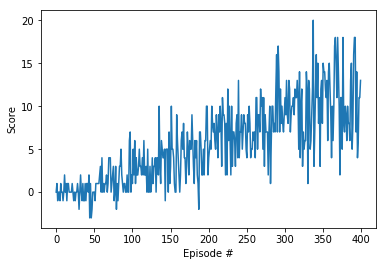

In [11]:
def train(
    agent,
    max_episodes, # (int): maximum number of training episodes
    max_steps, # (int): maximum number of steps per episode
    goal_score, # (int): average score to achive over 100 episodes 
    epsilon_start, # (float): start value of epsilon, for epsilon-greedy action selection
    epsilon_end, # (float): minimum value of epsilon
    epsilon_decay, # (float): multiplicative factor (per episode) for decreasing epsilon
    sample_exp_start, # (float): start value fo importance-sampling exponent
    sample_exp_end,  # (float): end value fo importance-sampling exponent,
    log_every
):
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    epsilon = epsilon_start # initialize epsilon
    
    log_step = 0
    
    sample_exp = sample_exp_start
    sample_exp_step = (sample_exp_end - sample_exp_start) / max_episodes
    
    for episode in range(1, max_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # get the current state
        score = 0 # initialize the score
        
        for step in range(max_steps):
            action = agent.act(state, epsilon)
            
            env_info = env.step(action)[brain_name] # send the action to the environment
            next_state = env_info.vector_observations[0] # get the next state
            reward = env_info.rewards[0] # get the reward
            done = env_info.local_done[0] # see if episode has finished
            
            if log_every is not None:
                log_step = (log_step + 1) % log_every
                log = log_step == 0
            else:
                log = False
                
            agent.perceive(state, action, reward, next_state, done, sample_exp, log)
            
            state = next_state
            score += reward
            
            if done:
                break
        
        scores_window.append(score) # save most recent score
        scores.append(score) # save most recent score
        epsilon = max(epsilon_end, epsilon_decay * epsilon) # decrease epsilon
        sample_exp += sample_exp_step # increase important-sampling exponent
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
        if np.mean(scores_window) >= goal_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    
    return scores

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

agent = PriorityReplayAgent(
    state_size=state_size, 
    action_size=action_size,
    memory_size=int(1e5),
    batch_size=64,
    priority_exp=0.5,
    sort_every=int(1e4),
    learn_every=4,
    learn_rate=5e-4,
    discount_factor=0.99,
    soft_update_factor=1e-3,
    seed=0
)

scores = train(
    agent=agent,  
    max_episodes=400, 
    max_steps=2000, 
    goal_score=20, 
    epsilon_start=1.0, 
    epsilon_end=0.01,
    epsilon_decay=0.995,
    sample_exp_start=0.3,
    sample_exp_end=1,
    log_every=None
)

plot_scores(scores)

#### Test the agent

Important to set epsilon to a non-zero value to avoid the agent getting stuck.

In [ ]:
def test(agent, eps):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0] # get the current state
    score = 0 # initialize the score

    while True:
        action = agent.act(state, eps) # select an action
        env_info = env.step(action)[brain_name] # send the action to the environment
        next_state = env_info.vector_observations[0] # get the next state
        reward = env_info.rewards[0] # get the reward
        done = env_info.local_done[0] # see if episode has finished
        score += reward # update the score
        state = next_state # roll over the state to next time step
        
        if done: # exit loop if episode finished
            break
    
    print("Score: {}".format(score))
    
test(agent, eps=0.05)

In [ ]:
env.close()